In [1]:
import os 
if not os.path.isfile('data.zip'):
    !wget https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip
    !unzip -n data.zip
    print('data downloaded.')
else:
    print('data already existed.')

--2025-05-04 05:38:08--  https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56278154 (54M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  53.67M   350MB/s    in 0.2s    

2025-05-04 05:38:10 (350 MB/s) - ‘data.zip’ saved [56278154/56278154]

Archive:  data.zip
  inflating: Test_Dst_NoAuction_DecPre_CF_7.txt  
  inflating: Test_Dst_NoAuction_DecPre_CF_9.txt  
  inflating: Test_Dst_NoAuction_DecPre_CF_8.txt  
  inflating: Train_Dst_NoAuction_DecPre_CF_7.txt  
data downloaded.


In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [6]:
dec_data = np.loadtxt('Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [7]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)


torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [8]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.3500, 0.0258, 0.3496,  ..., 0.0129, 0.3486, 0.0018],
          [0.3500, 0.0258, 0.3496,  ..., 0.0129, 0.3486, 0.0018],
          [0.3500, 0.0258, 0.3496,  ..., 0.0129, 0.3487, 0.0021],
          ...,
          [0.3504, 0.0038, 0.3500,  ..., 0.0022, 0.3486, 0.0018],
          [0.3503, 0.0033, 0.3495,  ..., 0.0094, 0.3484, 0.0050],
          [0.3503, 0.0053, 0.3497,  ..., 0.0094, 0.3486, 0.0018]]]],
       dtype=torch.float64)
tensor([2.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [9]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [10]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [11]:
summary(model, (1, 1, 100, 40))


Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [13]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses


In [14]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=20)

  5%|████▋                                                                                        | 1/20 [05:50<1:50:51, 350.09s/it]

model saved
Epoch 1/20, Train Loss: 0.9244,           Validation Loss: 0.9796, Duration: 0:05:50.094558, Best Val Epoch: 0


 10%|█████████▎                                                                                   | 2/20 [11:39<1:44:57, 349.85s/it]

model saved
Epoch 2/20, Train Loss: 0.8266,           Validation Loss: 0.9748, Duration: 0:05:49.670791, Best Val Epoch: 1


 15%|█████████████▉                                                                               | 3/20 [17:31<1:39:23, 350.77s/it]

model saved
Epoch 3/20, Train Loss: 0.7903,           Validation Loss: 0.9007, Duration: 0:05:51.873642, Best Val Epoch: 2


 20%|██████████████████▌                                                                          | 4/20 [23:23<1:33:37, 351.08s/it]

Epoch 4/20, Train Loss: 0.7710,           Validation Loss: 0.9108, Duration: 0:05:51.557720, Best Val Epoch: 2


 25%|███████████████████████▎                                                                     | 5/20 [29:14<1:27:49, 351.32s/it]

model saved
Epoch 5/20, Train Loss: 0.7568,           Validation Loss: 0.8869, Duration: 0:05:51.739822, Best Val Epoch: 4


 30%|███████████████████████████▉                                                                 | 6/20 [33:05<1:12:22, 310.16s/it]

model saved
Epoch 6/20, Train Loss: 0.7466,           Validation Loss: 0.8866, Duration: 0:03:50.265491, Best Val Epoch: 5


 35%|████████████████████████████████▌                                                            | 7/20 [36:52<1:01:21, 283.19s/it]

model saved
Epoch 7/20, Train Loss: 0.7388,           Validation Loss: 0.8780, Duration: 0:03:47.662714, Best Val Epoch: 6


 40%|██████████████████████████████████████                                                         | 8/20 [40:39<53:02, 265.17s/it]

Epoch 8/20, Train Loss: 0.7313,           Validation Loss: 0.8810, Duration: 0:03:46.592236, Best Val Epoch: 6


 45%|██████████████████████████████████████████▊                                                    | 9/20 [44:27<46:29, 253.62s/it]

model saved
Epoch 9/20, Train Loss: 0.7248,           Validation Loss: 0.8770, Duration: 0:03:48.209849, Best Val Epoch: 8


 50%|███████████████████████████████████████████████                                               | 10/20 [48:15<40:57, 245.77s/it]

Epoch 10/20, Train Loss: 0.7187,           Validation Loss: 0.8819, Duration: 0:03:48.186189, Best Val Epoch: 8


 55%|███████████████████████████████████████████████████▋                                          | 11/20 [52:04<36:03, 240.41s/it]

Epoch 11/20, Train Loss: 0.7142,           Validation Loss: 0.8810, Duration: 0:03:48.249484, Best Val Epoch: 8


 60%|████████████████████████████████████████████████████████▍                                     | 12/20 [55:52<31:33, 236.66s/it]

model saved
Epoch 12/20, Train Loss: 0.7089,           Validation Loss: 0.8764, Duration: 0:03:48.095540, Best Val Epoch: 11


 65%|█████████████████████████████████████████████████████████████                                 | 13/20 [59:40<27:17, 234.00s/it]

Epoch 13/20, Train Loss: 0.7045,           Validation Loss: 0.8817, Duration: 0:03:47.867946, Best Val Epoch: 11


 70%|████████████████████████████████████████████████████████████████▍                           | 14/20 [1:03:28<23:13, 232.25s/it]

Epoch 14/20, Train Loss: 0.7008,           Validation Loss: 0.8876, Duration: 0:03:48.213408, Best Val Epoch: 11


 75%|█████████████████████████████████████████████████████████████████████                       | 15/20 [1:07:15<19:14, 230.82s/it]

Epoch 15/20, Train Loss: 0.6964,           Validation Loss: 0.8850, Duration: 0:03:47.491809, Best Val Epoch: 11


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 16/20 [1:11:01<15:16, 229.22s/it]

Epoch 16/20, Train Loss: 0.6941,           Validation Loss: 0.8917, Duration: 0:03:45.497490, Best Val Epoch: 11


 85%|██████████████████████████████████████████████████████████████████████████████▏             | 17/20 [1:14:24<11:04, 221.49s/it]

Epoch 17/20, Train Loss: 0.6909,           Validation Loss: 0.8862, Duration: 0:03:23.520666, Best Val Epoch: 11


 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 18/20 [1:16:19<06:18, 189.25s/it]

Epoch 18/20, Train Loss: 0.6877,           Validation Loss: 0.8822, Duration: 0:01:54.200613, Best Val Epoch: 11


 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 19/20 [1:18:02<02:43, 163.45s/it]

Epoch 19/20, Train Loss: 0.6858,           Validation Loss: 0.8852, Duration: 0:01:43.347997, Best Val Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:19:45<00:00, 239.30s/it]

Epoch 20/20, Train Loss: 0.6840,           Validation Loss: 0.8840, Duration: 0:01:43.605010, Best Val Epoch: 11


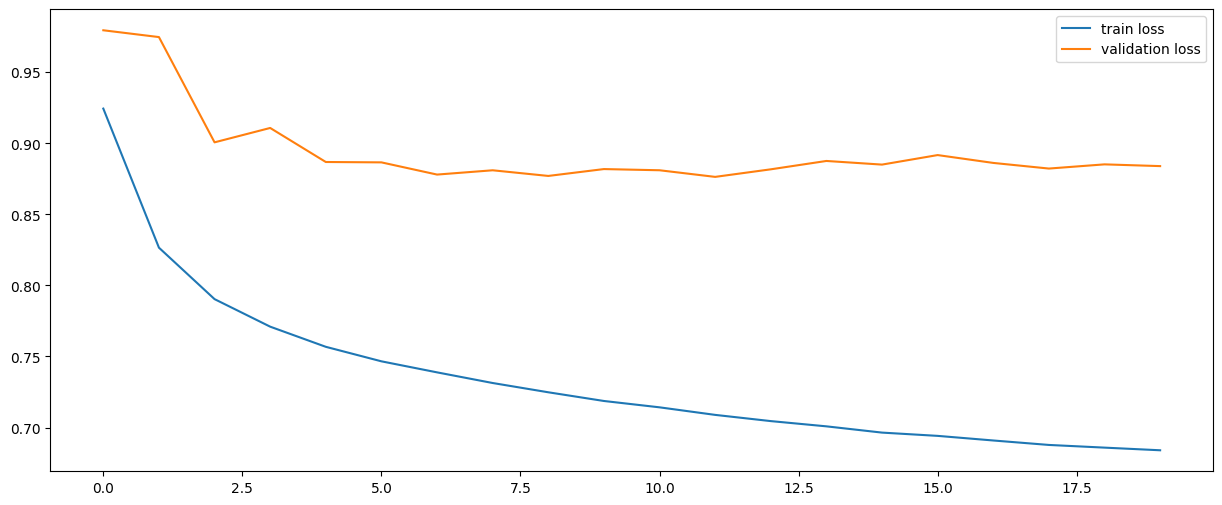

In [17]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [20]:
model = torch.load('best_val_model_pytorch', weights_only=False)

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.7343


In [21]:
model = torch.load('best_val_model_pytorch', weights_only=False)

n_correct = 0.
n_total = 0.
for inputs, targets in val_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.6638
